In [20]:
from __future__ import print_function, division
import keras.backend as K
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from random import sample
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import sklearn
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Layer, Dropout, RNN, LSTMCell, SimpleRNNCell,Bidirectional,LSTM,SimpleRNN
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, Flatten,LeakyReLU,ReLU,Lambda 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from functools import partial
from IPython.core.interactiveshell import InteractiveShell
from keras import metrics, losses
pd.options.display.max_rows = 2000

In [2]:
tf.compat.v1.disable_eager_execution() # This code use some functions that do not support eager_execution.
gpu = tf.config.experimental.get_visible_devices('GPU')[0] # If you use the multiple GPU, it only use the first one.
tf.config.experimental.set_memory_growth(device = gpu, enable = True) # It unlock the GPU limit.

In [16]:
## Load the Population dataset (=h-population)
# individual attributes collected from 2006, 2010, and 2016 NHTS data in South Korea
x_population = pd.read_csv('data/data_NHTSint_indiv.csv') 
le = LabelEncoder()

## Transform the categorical attributes into the form of label (=integer categories)
for col in x_population.columns:
    x_population[col] = le.fit_transform(x_population[col])
x_population = x_population.apply(lambda x: x.astype('category')) # Note that [5,10] in Age is not the first factors 


## Sample the 5% of entire dataset (=h-sample)
_,x_sample = train_test_split(x_population,test_size=0.05,shuffle=True,random_state=1004)

## Define the array regarding the number of categories in each attribute
# The arrays will be used in the following preprocesing
cat_groups = [0]
for col in x_population.columns:
    cat_groups.append(x_population[col].nunique())
    
cat_groups = np.cumsum(cat_groups)
cat_groups_n = len(cat_groups)-1

In [17]:
## Load the pretrained self-supervised embedding networks (Figure 4)
mlm_model = tf.keras.models.load_model(
    "MLM_Embed_Indiv5_New.h5")
embedding_layers =  mlm_model.layers[13:26] # You can find a embedding layers from mlm_model.summary()


## Define the functions to transform the categorical space into the embedding space
def convert_to_embedding(samples):
    samples_emb = []
    for i in range(len(embedding_layers)):
        emb_weight = embedding_layers[i].get_weights()[0]
        trgt = samples[:,range(n_uni_col[i],n_uni_col[i+1])]
        samples_emb.append(np.dot(trgt,emb_weight))
    
    return(np.concatenate(samples_emb,axis=1))

def convert_to_embedding_tensor(y_pred):
    samples_emb = []
    for i in range(len(embedding_layers)):
        emb_weight = embedding_layers[i].get_weights()[0]
        trgt = y_pred[:,n_uni_col[i]:n_uni_col[i+1]]
        samples_emb.append(tf.tensordot(trgt,emb_weight,1))
    
    return(tf.concat(samples_emb,axis=1))

## Define the functions for measuring the "Precision and Recall"

def compute_pairwise_distance(data_x, data_y=None):

    if data_y is None:
        data_y = data_x
    dists = sklearn.metrics.pairwise_distances(
        data_x, data_y, metric='l2', n_jobs=-1)
    return dists

def compute_pairwise_distance_tensor(A,B):
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)
    # na as a row and nb as a co"lumn vectors
    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])
    
    # return pairwise euclidead difference matrix
    dists = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 1e-9))

    return dists

def compute_pairwise_hamming_distance(data_x, data_y=None):

    if data_y is None:
        data_y = data_x
    dists = sklearn.metrics.pairwise_distances(
        data_x, data_y, metric='hamming', n_jobs=-1)
    return dists

def compute_pairwise_hamming_distance_tensor(A,B):
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)
    # na as a row and nb as a column vectors
    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])
    
    # return pairwise euclidead difference matrix
    hamming_dists = na - 2*tf.matmul(A, B, False, True) + nb

    return hamming_dists

In [39]:
## Define the tuned training hyperparameters
x_train = pd.get_dummies(x_sample)
epochs = 200
batch_size = 256
latent_dim =  32
intermediate_dim = [256,128.64]
epsilon_std = 1
optimizer = Adam(learning_rate=0.0005, beta_1=0.5, beta_2=0.9)

## Define the array regarding the categories in label + dummy form 
n_uni_col = [x_sample[i].nunique() for i in x_sample.columns]
n_uni_col = [0]+n_uni_col
n_uni_col = np.cumsum(n_uni_col)

col_pop = x_train.columns.values.copy()
for i in range(len(col_pop)):
    col_pop[i] = col_pop[i].split('_', 1)[1]
col_pop = col_pop.astype('int64')

In [31]:
## Define the dummy form of h-populatoin and h-sample for applying the embedding network 
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_population)
x_sam_dum = enc.transform(x_sample).toarray()

## Transform the dummy form data into the embedding space
sam_embed = convert_to_embedding(x_sam_dum)
sam_embed_tensor = tf.convert_to_tensor(sam_embed,dtype='float32')
x_sam_dum_tensor = tf.convert_to_tensor(x_sam_dum,dtype='float32')
#sam_embed_tensor = tf.constant(sam_embed,dtype='float32')
#sam_embed_tensor = tf.keras.initializers.Constant(sam_embed)

In [32]:
## Define the function to construct the VAE

def build_VAE(beta1, beta2):
   
    ## Encoder network 
    img = Input(shape=(x_train.shape[1]),name="main_input")
      
    h = Dense(intermediate_dim[0],activation='relu')(img)
    for num_layer in range(len(intermediate_dim)-1):
        h = Dense(intermediate_dim[num_layer+1],activation='relu')(h)

    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    ## Reparameterization 
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z = Lambda(sampling)([z_mean, z_log_var])
      
    ## Decoder network
    decoder_h = [Dense(intermediate_dim[len(intermediate_dim)-i-1], activation = "relu")
                for i in range(len(intermediate_dim)) ]

    h_decoded = decoder_h[0](z)     

    for decoder_h_ in decoder_h[1:]:
        h_decoded = decoder_h_(h_decoded) 
        
    x_decoder_mean_cat = [Dense(x_sample[i].nunique(),activation='softmax') 
              for i in x_sample.columns]
    
    x_decoded_mean_cat = [x_decoder_mean_cat_(h_decoded)
                      for x_decoder_mean_cat_ in x_decoder_mean_cat]
    
    x_decoded_mean = Concatenate()(x_decoded_mean_cat)
    

    ## Define the Custom Losses 
    # Total loss (used as loss in model.compile below)
    def vae_loss(y_true, y_pred):
        # categorical loss
        recon_cat = 0
        for g_i in range(cat_groups_n):    
            g_i_beg = cat_groups[g_i]
            g_i_end = cat_groups[g_i + 1]
            recon_cat += metrics.categorical_crossentropy(y_true[:, g_i_beg:g_i_end], y_pred[:, g_i_beg:g_i_end])
        # KL loss
        kl = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        
        # RBD loss (Discrete Hamming distance)
        Hamming_distance = compute_pairwise_hamming_distance_tensor(y_pred,x_sam_dum_tensor)
        Hamming_nearest_distance = tf.math.reduce_min(Hamming_distance,axis=1)
        
        # RAD Loss (Discrete Hamming distance)
        Hamming_mean_distance = tf.math.reduce_mean(Hamming_distance,axis=1)
        # Embed = convert_to_embedding_tensor(y_pred) # Continuous Embedding distance
        # Embed_distance = compute_pairwise_distance_tensor(Embed,sam_embed_tensor)

        # total loss
        loss = K.mean(recon_cat + 1.0 * kl + beta1* Hamming_nearest_distance - beta2*Hamming_mean_distance)
        return loss
    
    # KL loss (used as metrics in model.compile below)
    def KL_loss(y_true, y_pred):
        kl = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(1.0 * kl)
    
    # categorical loss (used as metrics in model.compile below)
    def recon_loss_cat(y_true, y_pred):
        recon_cat = 0
        for g_i in range(cat_groups_n):    
            g_i_beg = cat_groups[g_i]
            g_i_end = cat_groups[g_i + 1]
            recon_cat += metrics.categorical_crossentropy(y_true[:, g_i_beg:g_i_end], y_pred[:, g_i_beg:g_i_end])
        return K.mean(recon_cat * 1.0)
    
    # RBD loss
    def OOS_loss(y_true, y_pred):
        Hamming_distance = compute_pairwise_hamming_distance_tensor(y_pred,x_sam_dum_tensor)
        Hamming_nearest_distance = tf.math.reduce_min(Hamming_distance,axis=1)
        
        return K.mean(beta1*Hamming_nearest_distance)

    # RAD Loss
    def div_loss(y_true,y_pred):

        Hamming_distance = compute_pairwise_hamming_distance_tensor(y_pred,x_sam_dum_tensor)
        Hamming_mean_distance = tf.math.reduce_mean(Hamming_distance,axis=1)
        
        return K.mean(-beta2*Hamming_mean_distance)
    
    
    ## build a VAE model (encoder+decoder)
    model = Model(img, x_decoded_mean)
    
    ## Run training
    model.compile(optimizer=optimizer, loss=vae_loss, metrics=[KL_loss, recon_loss_cat,OOS_loss,div_loss])   
    
    # define a sampling model (decoder only)
    sam_z = Input(shape=(latent_dim),name="sam_z")
    h_decoded_sample = decoder_h[0](sam_z)
    for i in range(len(intermediate_dim)-1):
        h_decoded_sample = decoder_h[i+1](h_decoded_sample)

    x_decoded_sample_cat = [x_decoder_mean_cat_(h_decoded_sample)
                                for x_decoder_mean_cat_ in x_decoder_mean_cat]
    x_decoded_sample = Concatenate()(x_decoded_sample_cat)
    generator = Model(sam_z, x_decoded_sample)

    return model,generator


In [33]:
## Define funstions to evaluate the generated dat

# Caculate the mean of the Jensen-Shannon distance (Not in the paper) 
def mean_JSD(samples,resamples):
    Marg_JSD = []
    for col in samples.columns:
        resam = pd.value_counts(resamples[col]).sort_index()
        sam = pd.value_counts(samples[col]).sort_index()
        tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
        tab = tab.fillna(0)
        Marg_JSD.append(jensenshannon(tab.iloc[:,0], tab.iloc[:,1]))
     
    bi_index = combinations(samples.columns,2)
    bi_index = list(bi_index)
    col1,col2 = bi_index[0]

    Bi_JSD = []
    for col1,col2 in bi_index:
        resam = pd.DataFrame(pd.crosstab(resamples[col1],resamples[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
        sam = pd.DataFrame(pd.crosstab(samples[col1],samples[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
        tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
        tab = tab.fillna(0)
        Bi_JSD.append(jensenshannon(tab.iloc[:,0], tab.iloc[:,1]))

    return([Marg_JSD,Bi_JSD])

# Caculate the stadardized root mean squared error
def SRMSE(x_population,resamples):
    
    ## Aggregated Marginal distribution
    sam_marg_cnt = []
    resam_marg_cnt = []
    for col in x_population.columns:
        resam = pd.value_counts(resamples[col]).sort_index()
        sam = pd.value_counts(x_population[col]).sort_index()
        tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
        tab = tab.fillna(0)
        sam_marg_cnt.append(tab.iloc[:,1].values/x_population.shape[0])
        resam_marg_cnt.append(tab.iloc[:,0].values/resamples.shape[0])
    
    sam_marg_cnt = np.concatenate(sam_marg_cnt)
    resam_marg_cnt = np.concatenate(resam_marg_cnt)
    
    ## Aggregated Bivariate distribution    
    bi_index = combinations(x_population.columns,2)
    bi_index = list(bi_index)
    col1,col2 = bi_index[0]

    sam_bi_cnt  = []
    resam_bi_cnt = []
    for col1,col2 in bi_index:
        resam = pd.DataFrame(pd.crosstab(resamples[col1],resamples[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
        sam = pd.DataFrame(pd.crosstab(x_population[col1],x_population[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
        tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
        tab = tab.fillna(0)
        sam_bi_cnt.append(tab.iloc[:,1].values/x_population.shape[0])
        resam_bi_cnt.append(tab.iloc[:,0].values/resamples.shape[0])

    sam_bi_cnt = np.concatenate(sam_bi_cnt)
    resam_bi_cnt = np.concatenate(resam_bi_cnt)
    
    # SRMSE for marginal distribution
    rmse_mar = np.linalg.norm(sam_marg_cnt - resam_marg_cnt) / np.sqrt(len(sam_marg_cnt))
    ybar_mar = sam_marg_cnt.mean()
    srmse_mar = rmse_mar / ybar_mar

    # SRMSE for bivariate distribution
    rmse_bi = np.linalg.norm(sam_bi_cnt - resam_bi_cnt) / np.sqrt(len(sam_bi_cnt))
    ybar_bi = sam_bi_cnt.mean()
    srmse_bi = rmse_bi / ybar_bi
    
    return([srmse_mar,srmse_bi])  

In [58]:
import itertools
from random import sample
from scipy.spatial.distance import jensenshannon
from itertools import combinations

## Define the hyperparameters to be calibrated (wegihts for RBD (beta 1) and RAD (beta 2))
beta1_grid = [0.75]
beta2_grid = [0.3]
param_grid = []
for r in itertools.product(beta1_grid, beta2_grid):
    param_grid.append([r[0],r[1]])


# Load the dataset
X_train = pd.get_dummies(train_test_split(x_population,test_size=0.05,shuffle=True,random_state=1004)[1]).values.astype("float32")

for beta in param_grid:
    model,generator = build_VAE(beta1 = beta[0], beta2 = beta[1])
    model.fit(
        x = X_train,
        y = X_train,
        shuffle = True,
        epochs = epochs,
        batch_size = batch_size,
        validation_split=0.3)

    #generator.save_weights('C:/Users/euijin/Documents/modelCollection/VAE/VAE_OOSdiv'+str(beta), overwrite=True)
    model.save_weights('C:/Users/euijin/Documents/modelCollection/VAE/VAE_OOSdivH_Tutorial_'+str(beta), overwrite=True)

Train on 37321 samples, validate on 15995 samples
Epoch 1/200
37321/37321 [==============================] - ETA: 0s - loss: 16.3872 - KL_loss: 0.5021 - recon_loss_cat: 16.1618 - OOS_loss: 2.3291 - div_loss: -2.6096

C:\Users\euijin\.conda\envs\DGM\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


37321/37321 [==============================] - 8s 209us/sample - loss: 16.3872 - KL_loss: 0.5021 - recon_loss_cat: 16.1618 - OOS_loss: 2.3291 - div_loss: -2.6096 - val_loss: 13.8317 - val_KL_loss: 1.6267 - val_recon_loss_cat: 13.2565 - val_OOS_loss: 1.8176 - val_div_loss: -2.8743
Epoch 2/200
37321/37321 [==============================] - 4s 98us/sample - loss: 13.3730 - KL_loss: 1.7778 - recon_loss_cat: 12.9841 - OOS_loss: 1.5946 - div_loss: -2.9838 - val_loss: 13.1802 - val_KL_loss: 1.8721 - val_recon_loss_cat: 12.8354 - val_OOS_loss: 1.4936 - val_div_loss: -3.0203
Epoch 3/200
37321/37321 [==============================] - 4s 98us/sample - loss: 13.0845 - KL_loss: 1.9041 - recon_loss_cat: 12.7095 - OOS_loss: 1.4901 - div_loss: -3.0196 - val_loss: 12.9224 - val_KL_loss: 2.0262 - val_recon_loss_cat: 12.4783 - val_OOS_loss: 1.4600 - val_div_loss: -3.0425
Epoch 4/200
37321/37321 [==============================] - 4s 97us/sample - loss: 12.6796 - KL_loss: 2.1397 - recon_loss_cat: 12.1360 -

In [84]:
def generate_images(size=x_sample.shape[0]):
    model.load_weights('C:/Users/euijin/Documents/modelCollection/VAE/VAE_OOSdivH_Tutorial_'+str(beta))
    noise = np.random.normal(0, 1,(size,latent_dim))
    gen_imgs = generator.predict(noise)
       
    return gen_imgs


def wide_to_long(samples_pop):
    resamples = []
    for j in range(samples_pop.shape[0]):
        if(type(samples_pop) is np.ndarray):
            sam = samples_pop[j]
        else:
            sam = samples_pop.values[j]
        resamples_row = []
        for i in range(len(n_uni_col)-1):
            idx = range(n_uni_col[i],n_uni_col[i+1])
            resamples_row = np.append(resamples_row,np.random.choice(col_pop[idx],p=sam[idx],size=1))
        resamples = np.concatenate((resamples,resamples_row),axis=0)
    resamples = resamples.reshape(samples_pop.shape[0],len(n_uni_col)-1 )
    resamples = pd.DataFrame(resamples,columns= x_sample.columns.to_list())
    resamples = resamples.apply(lambda x: x.astype('category'))
    return(resamples)

def mean_JSD(samples,resamples):
    Marg_JSD = []
    for col in samples.columns:
        resam = pd.value_counts(resamples[col]).sort_index()
        sam = pd.value_counts(samples[col]).sort_index()
        tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
        tab = tab.fillna(0)
        Marg_JSD.append(jensenshannon(tab.iloc[:,0], tab.iloc[:,1]))
     

    bi_index = combinations(samples.columns,2)
    bi_index = list(bi_index)
    col1,col2 = bi_index[0]

    Bi_JSD = []
    for col1,col2 in bi_index:
        resam = pd.DataFrame(pd.crosstab(resamples[col1],resamples[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
        sam = pd.DataFrame(pd.crosstab(samples[col1],samples[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
        tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
        tab = tab.fillna(0)
        Bi_JSD.append(jensenshannon(tab.iloc[:,0], tab.iloc[:,1]))

    return([Marg_JSD,Bi_JSD])

In [85]:
gen_sample = generate_images(x_population.shape[0])

In [ ]:
resamples = wide_to_long(gen_sample)
#resamples = resamples.astype('int64')

In [ ]:
from scipy.spatial.distance import jensenshannon
from itertools import combinations
Marg_JSD,Bi_JSD = mean_JSD(x_sample,resamples)
print(np.mean(Marg_JSD),np.mean(Bi_JSD))
Marg_JSD,Bi_JSD = mean_JSD(x_population,resamples)
print(np.mean(Marg_JSD),np.mean(Bi_JSD))

In [ ]:
## Extract the attribute combinations from the h-population, h-sample, and generated data
p_pop = x_population.iloc[:,0].astype(str)
for i in range(x_population.shape[1]-1):
    p_pop = p_pop+x_population.iloc[:,(i+1)].astype(str)
    
p_gen = resamples.astype('int64').iloc[:,0].astype(str)
for i in range(resamples.astype('int64').shape[1]-1):
    p_gen = p_gen+resamples.astype('int64').iloc[:,(i+1)].astype(str)
    
p_sam = x_sample.iloc[:,0].astype(str)
for i in range(x_sample.shape[1]-1):
    p_sam = p_sam+x_sample.iloc[:,(i+1)].astype(str)
    
    
Precision.append(np.mean(p_gen.isin(p_pop)))
Recall.append(np.mean(p_pop.isin(p_gen)))
print(num); print(Precision); print(Recall)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4, ncols=3)
ax = np.reshape(ax,(-1))
colors = ['red', 'lime']
label=['Generated', 'Training']

i=0
for i in range(len(x_sample.columns[:-1])):
    
    resam = pd.value_counts(resamples.iloc[:,i]).sort_index()
    sam = pd.value_counts(x_sample.iloc[:,i]).sort_index()
    tab = pd.merge(resam,sam,left_index=True, right_index=True,how='right')
    tab = tab.fillna(0)
    ticks = np.arange(tab.shape[0])
    w = 0.3
    ax[i].bar(ticks-0.5*w,tab.iloc[:,0],align='center',width =  w,color=colors[0], label=label[0])
    ax[i].bar(ticks+0.5*w,tab.iloc[:,1],align='center',width =  w,color=colors[1], label=label[1])
    ax[i].set_title(x_sample.columns[i],fontsize=8)
    ax[i].tick_params(axis='y', labelsize=5)
    #ax[i].autoscale(tight=True)
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels = tab.index.to_list(),fontsize=5,rotation=40)

plt.subplots_adjust(left=0.15, right=0.85, top=0.90,bottom=0.10,wspace = 0.2,hspace=0.2)
plt.rcParams["figure.figsize"] = (8,12)
plt.rcParams["legend.loc"] = 'upper right'
fig.tight_layout()
plt.show()
plt.savefig('line_plot_hq.png', dpi=300)

In [72]:
# Compute two vector comparison
# compare two vectors: Y_test (true) and Y_pred (predicted)
from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText("Test", loc=2)

def compute_stat(Y_test, Y_pred, do_plot, plot_log):
    Y_test, Y_pred = np.array(Y_test), np.array(Y_pred)
    
    corr_mat = np.corrcoef(Y_test, Y_pred)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(Y_test - Y_pred).mean()
    # RMSE
    rmse = np.linalg.norm(Y_test - Y_pred) / np.sqrt(len(Y_test))
    # SRMSE
    ybar = Y_test.mean()
    srmse = rmse / ybar
    # r-square
    u = np.sum((Y_pred - Y_test)**2)
    v = np.sum((Y_test - ybar)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    if do_plot:
        min_Y = min([min(Y_test),min(Y_pred)])
        max_Y = max([max(Y_test),max(Y_pred)])
        w = max_Y - min_Y
        max_Y += w * 0.02
        text = ['SMRSE = {:.3f}'.format(stat['srmse']),
                'Corr = {:.3f}'.format(stat['corr']),
                '$R^2$ = {:.3f}'.format(stat['r2'])]
        text = '\n'.join(text)
        plt.annotate(text , xy=(0.10, 0.75), xycoords='axes fraction')
        plt.plot(Y_test, Y_pred, '.', alpha=0.5, ms=10, color='seagreen', markeredgewidth=0)
        plt.plot([min_Y, max_Y], [min_Y, max_Y], ls='--', color='gray', linewidth=1.0)
        plt.axis([min_Y, max_Y, min_Y, max_Y])
        plt.xlabel('Obs')
        plt.ylabel('Gen')
        if plot_log:
            eps = 1e-6
            plt.axis([max(min_Y, eps), max_Y, max(min_Y, eps), max_Y])
            plt.yscale('log')
            plt.xscale('log')
        #fig.savefig(os.path.join(temp_dir, '{}.pdf'.format(ylabel)), dpi=fig.dpi)
        #plt.show()
    return stat

In [73]:
%matplotlib widget
import matplotlib.pyplot as plt
import subprocess


## Aggregated Marginal distribution

sam_marg_cnt = []
resam_marg_cnt = []
for col in x_population.columns:
    resam = pd.value_counts(resamples[col]).sort_index()
    sam = pd.value_counts(x_population[col]).sort_index()
    tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
    tab = tab.fillna(0)
    sam_marg_cnt.append(tab.iloc[:,1].values/x_population.shape[0])
    resam_marg_cnt.append(tab.iloc[:,0].values/resamples.shape[0])

sam_marg_cnt = np.concatenate(sam_marg_cnt)
resam_marg_cnt = np.concatenate(resam_marg_cnt)

  
## Aggregated Bivariate distribution
    
bi_index = combinations(x_population.columns,2)
bi_index = list(bi_index)
col1,col2 = bi_index[0]

sam_bi_cnt  = []
resam_bi_cnt = []
for col1,col2 in bi_index:
    resam = pd.DataFrame(pd.crosstab(resamples[col1],resamples[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
    sam = pd.DataFrame(pd.crosstab(x_population[col1],x_population[col2],rownames=[col1],colnames=[col2]).stack().sort_index())
    tab = pd.merge(resam,sam,left_index=True, right_index=True,how='outer')
    tab = tab.fillna(0)
    sam_bi_cnt.append(tab.iloc[:,1].values/x_population.shape[0])
    resam_bi_cnt.append(tab.iloc[:,0].values/resamples.shape[0])

sam_bi_cnt = np.concatenate(sam_bi_cnt)
resam_bi_cnt = np.concatenate(resam_bi_cnt)

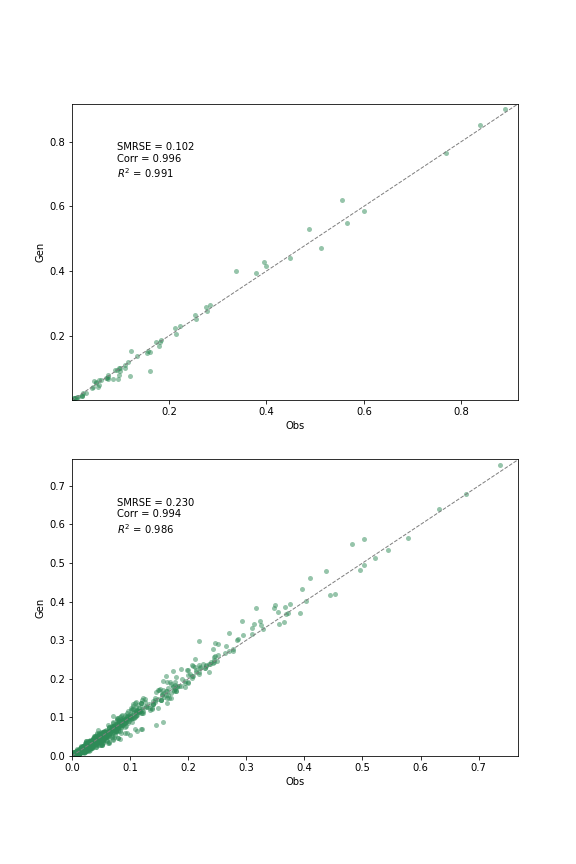

In [74]:
plt.subplot(2,1,1)
compute_stat(sam_marg_cnt,resam_marg_cnt,True,False)
plt.subplot(2,1,2)
compute_stat(sam_bi_cnt,resam_bi_cnt,True,False)

#plt.subplots_adjust(left=0.15, right=0.85, top=0.90,bottom=0.10,wspace = 0.2,hspace=0.2)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["legend.loc"] = 'upper right'
#fig.tight_layout()
plt.savefig('Fig_distribution_2021.png', dpi=300)
plt.show()